In [2]:
;;
#require "pkp"

/home/hennequi/.opam/4.07.1+flambda/lib/juplot: added to search path
/home/hennequi/.opam/4.07.1+flambda/lib/juplot/juplot.cma: loaded
/home/hennequi/.opam/4.07.1+flambda/lib/lbfgs/fortran: added to search path
/home/hennequi/.opam/4.07.1+flambda/lib/lbfgs/fortran/lbfgs_fortran.cma: loaded
/home/hennequi/.opam/4.07.1+flambda/lib/lbfgs: added to search path
/home/hennequi/.opam/4.07.1+flambda/lib/lbfgs/lbfgs.cma: loaded
/home/hennequi/.opam/4.07.1+flambda/lib/owl-lbfgs: added to search path
/home/hennequi/.opam/4.07.1+flambda/lib/owl-lbfgs/owl_lbfgs.cma: loaded
/home/hennequi/.opam/4.07.1+flambda/lib/owl-ode: added to search path
/home/hennequi/.opam/4.07.1+flambda/lib/owl-ode/owl_ode.cma: loaded
/home/hennequi/.opam/4.07.1+flambda/lib/sundialsml: added to search path
/home/hennequi/.opam/4.07.1+flambda/lib/sundialsml/sundials.cma: loaded
/home/hennequi/.opam/4.07.1+flambda/lib/sundialsml/sundials_top.cma: loaded
/home/hennequi/.opam/4.07.1+flambda/lib/owl-ode-sundials: added to search 

In [3]:
open Pkp.Reinforcement_learning

In [4]:
module MySolution = struct
  let other_mark = Solution.other_mark
  let empty_board = Solution.empty_board
  let transpose = Solution.transpose
  let is_full = Solution.is_full
  let mean = Solution.mean
  let play_game = Solution.play_game
end

module MySolution :
  sig
    val other_mark :
      Pkp.Reinforcement_learning.mark -> Pkp.Reinforcement_learning.mark
    val empty_board : Pkp.Reinforcement_learning.board
    val transpose :
      Pkp.Reinforcement_learning.board -> Pkp.Reinforcement_learning.board
    val is_full : Pkp.Reinforcement_learning.board -> bool
    val mean : float list -> float
    val play_game :
      ?display:(Pkp.Reinforcement_learning.board -> unit) ->
      finished:(Pkp.Reinforcement_learning.board -> bool) ->
      Pkp.Reinforcement_learning.player * Pkp.Reinforcement_learning.player ->
      Pkp.Reinforcement_learning.board
  end


In [5]:
module M = Make (MySolution)

module M :
  sig
    val optimal :
      Pkp.Reinforcement_learning.mark -> Pkp.Reinforcement_learning.player
    val random :
      Pkp.Reinforcement_learning.mark -> Pkp.Reinforcement_learning.player
    val play :
      ?display:bool ->
      Pkp.Reinforcement_learning.player * Pkp.Reinforcement_learning.player ->
      Pkp.Reinforcement_learning.mark option
  end


Let's run an example game between the optimal X player, and a random O player:

In [8]:
let result = M.play (M.random O, M.optimal X)

_,X,O
_,X,_
O,X,O


val result : Pkp.Reinforcement_learning.mark option = Some ...


Try running it several times to convince yourself that the optimal player does pretty well! Try also reversing the order of the players, so that the O player gets to start. What do you notice? Does the optimal player ever lose?

-----

Let us now define an O-player that interpolates between the optimal player (which is as strong as our optimal X-player) and a random player: every time it needs to chose a new board, it makes a random choice with probability $p$, and the optimal choice with probability $(1-p)$:

In [9]:
let playerO p =
 let dumb = M.random O in
 let opt = M.optimal O in
 let play b = if Random.float 1. < p then dumb.play b else opt.play b in
 { mark = O; play }

val playerO : float -> Pkp.Reinforcement_learning.player = <fun>


In [10]:
let playerX = M.optimal X

val playerX : Pkp.Reinforcement_learning.player =
  {Pkp.Reinforcement_learning.play = ...; mark = ...}


Let us try out such an intermediate player ─ you may want to play with parameter $p$, and swap the player ordering:

In [12]:
let result = M.play (playerO 0.5, playerX)

X,O,O
O,X,X
X,O,O


val result : Pkp.Reinforcement_learning.mark option = None


Let us now run many games, collect some statistics, and make pretty plots!

In [13]:
let stats p =
  let playerO = playerO p in
  let n_games = 1000 in
  let games = List.init n_games (fun _ -> M.play ~display:false (playerO, playerX)) in
  let n_wins = games |> List.filter (fun winner -> winner = Some X) |> List.length in
  let n_ties = games |> List.filter (fun winner -> winner = None) |> List.length in
  float n_wins /. float n_games, float n_ties /. float n_games

val stats : float -> float * float = <fun>


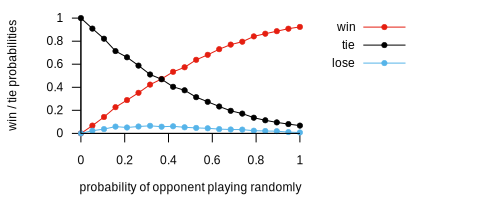

In [14]:
let () =
  let open Owl in
  let ps = Mat.linspace 0. 1. 20 in
  let results = ps |> Mat.to_array |> Array.map stats in
  let wins = results |> Array.map fst |> fun v -> Mat.of_array v 1 (-1) in
  let ties = results |> Array.map snd |> fun v -> Mat.of_array v 1 (-1) in
  let lose = Mat.(1. $- wins + ties) in
  let open Gp in
  let figure (module P : Plot) =
    P.plots
      [ item (L [ ps; wins ]) ~style:"lp pt 7 lc 7 ps 0.6" ~legend:"win"
      ; item (L [ ps; ties ]) ~style:"lp pt 7 lc 8 ps 0.6" ~legend:"tie"
      ; item (L [ ps; lose ]) ~style:"lp pt 7 lc 3 ps 0.6" ~legend:"lose"
      ]
      [ barebone
      ; set "key at graph 1.1, graph 1 top left"
      ; tics "out nomirror"
      ; borders [ `bottom; `left ]
      ; xlabel "probability of opponent playing randomly"
      ; ylabel "win / tie probabilities"
      ; margins [ `right 0.6 ]
      ]
  in
  Juplot.draw ~fmt:`svg ~size:(500, 200) figure

Take-home exercise: redo the stats above, in the case where the order of play gets decided randomly (50-50) at the beginning of every game!